In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel

import tensorflow as tf
from tensorflow import keras
from scipy.sparse import hstack, csr_matrix
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\Master\Desktop\ML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


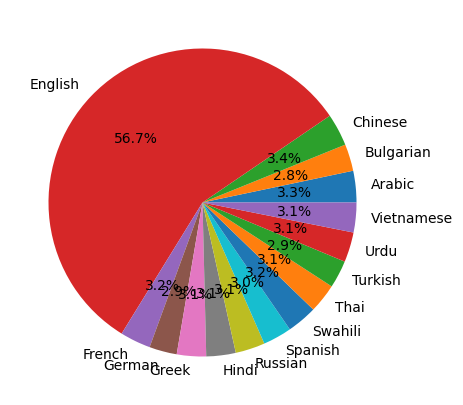

In [3]:
labels, frequencies = np.unique(train.language.values, return_counts=True)

plt.figure(figsize=(5, 5))
plt.pie(frequencies, labels=labels, autopct = '%1.1f%%')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split


train['text'] = train['premise'] + ' ' + train['hypothesis']
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42)

In [5]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
transformer_model = TFBertModel.from_pretrained(model_name)

c:\Users\Master\Desktop\ML\.venv\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Master\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
max_length = 128
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(), 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors='tf'
    )

X_train_tokens = tokenize_texts(X_train)
X_val_tokens = tokenize_texts(X_val)

In [7]:
print(f"X_train_tokens['input_ids'].shape: {X_train_tokens['input_ids'].shape}")
print(f"X_val_tokens['input_ids'].shape: {X_val_tokens['input_ids'].shape}")
print(f"Max token id in train: {tf.reduce_max(X_train_tokens['input_ids'])}")
print(f"Max token id in val: {tf.reduce_max(X_val_tokens['input_ids'])}")

X_train_tokens['input_ids'].shape: (9696, 128)
X_val_tokens['input_ids'].shape: (2424, 128)
Max token id in train: 29959
Max token id in val: 29959


In [8]:
max_token_id = tokenizer.vocab_size
X_train_tokens['input_ids'] = tf.where(X_train_tokens['input_ids'] >= max_token_id, max_token_id - 1, X_train_tokens['input_ids'])
X_val_tokens['input_ids'] = tf.where(X_val_tokens['input_ids'] >= max_token_id, max_token_id - 1, X_val_tokens['input_ids'])

In [9]:
from tensorflow.python.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D

input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

In [11]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping

#embedding = transformer_model([input_ids, attention_mask])[0]
sequence_output = transformer_model([input_ids, attention_mask])[0]
x = GlobalAveragePooling1D()(sequence_output)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

ValueError: Exception encountered when calling layer 'tf_bert_model' (type TFBertModel).

Data of type <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model' (type TFBertModel):
  • input_ids=["<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_ids')>", "<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'attention_mask')>"]
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False